In [1]:
# packages

import pathlib
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.integrate as integrate
from scipy import signal
from scipy.optimize import fsolve
from scipy.interpolate import interp2d
from sympy import symbols, Eq, solve, I, cos, exp, pi
import os
os.chdir(os.path.abspath(''))


In [34]:
# functions

def compute_transform_matrices(theta_blade, theta_yaw, theta_tilt, theta_cone):

    a1 = (  [1,0,0],
            [0, np.cos(theta_yaw), np.sin(theta_yaw)],
            [0, -np.sin(theta_yaw), np.cos(theta_yaw)])
    a2 = (  [np.cos(theta_tilt), 0, -np.sin(theta_tilt)],
            [0, 1, 0],
            [np.sin(theta_tilt), 0, np.cos(theta_tilt)])
    a12 = np.matmul(a2, a1)
    a21 = np.transpose(a12)
    
    a23 = ( [np.cos(theta_blade), np.sin(theta_blade), 0],
            [-np.sin(theta_blade), np.cos(theta_blade), 0],
            [0, 0, 1])
    a34 = ( [np.cos(theta_cone), 0, -np.sin(theta_cone)],
            [0, 1, 0],
            [np.sin(theta_cone), 0, np.cos(theta_cone)])
    
    a14 = np.matmul(np.matmul(a34,a23), a12)
    a41 = np.transpose(a14)

    return a21, a23, a41 

def compute_position(a21, a41, H, Ls, radius):
    
    rt = np.transpose([H,0,0])
    rs = np.matmul(a21, np.transpose([0,0,-Ls]))
    rb = np.matmul(a41, np.transpose([radius,0,0]))
    position = rt + rs + rb
    
    return position

def compute_tower_radius(x):

    if x <= H:
        a = a0
    else:
        a = 0
    
    return a


# interpolate airfoil (provided in course materials)

files=[ 'FFA-W3-241.txt',
        'FFA-W3-301.txt',
        'FFA-W3-360.txt',
        'FFA-W3-480.txt',
        'FFA-W3-600.txt',
        'cylinder.txt']

#Initializing tables    
cl_tab=np.zeros([105,6])
cd_tab=np.zeros([105,6])
cm_tab=np.zeros([105,6])
aoa_tab=np.zeros([105,])
fstat_tab=np.zeros([105,6])
Cl_inv_tab=np.zeros([105,6])
Cl_fs_tab=np.zeros([105,6])

#Reading of tables. Only do this once at startup of simulation
for i in range(np.size(files)):
    aoa_tab[:],cl_tab[:,i],cd_tab[:,i],cm_tab[:,i],fstat_tab[:,i],Cl_inv_tab[:,i],Cl_fs_tab[:,i] = np.loadtxt(files[i], skiprows=0).T

thick_prof=np.zeros(6)
thick_prof[0]=24.1
thick_prof[1]=30.1
thick_prof[2]=36
thick_prof[3]=48
thick_prof[4]=60
thick_prof[5]=100

def force_coeffs_10MW(angle_of_attack,thick,aoa_tab,cl_tab,cd_tab,cm_tab,fstat_tab, Cl_inv_tab,Cl_fs_tab):
    
    cl_aoa=np.zeros([1,6])
    cd_aoa=np.zeros([1,6])
    cm_aoa=np.zeros([1,6])
    fstat_aoa=np.zeros([1,6])
    Cl_inv_aoa=np.zeros([1,6])
    Cl_fs_aoa=np.zeros([1,6])
    
    #Interpolate to current angle of attack:
    for i in range(np.size(files)):
        cl_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cl_tab[:,i])
        cd_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cd_tab[:,i])
        cm_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cm_tab[:,i])
        fstat_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,fstat_tab[:,i])
        Cl_inv_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,Cl_inv_tab[:,i])
        Cl_fs_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,Cl_fs_tab[:,i])
    
    #Interpolate to current thickness:
    cl=np.interp (thick,thick_prof,cl_aoa[0,:])
    cd=np.interp (thick,thick_prof,cd_aoa[0,:])
    cm=np.interp (thick,thick_prof,cm_aoa[0,:])
    fstat=np.interp (thick,thick_prof,fstat_aoa[0,:])
    cl_inv=np.interp (thick,thick_prof,Cl_inv_aoa[0,:])
    cl_fs=np.interp (thick,thick_prof,Cl_fs_aoa[0,:])

    return cl, cd, cm , fstat, cl_inv, cl_fs



# BEM
def aeroelasticity(t_total=10, dt=0.1, V0=10, turb=False, theta_pitch=0, omega=1, control = False, M_matrix = np.zeros((3,3)), C_matrix=np.zeros((3,3)), K_matrix=np.zeros((3,3))):
    num = int(t_total / dt)+1 # number of time steps

    # creating empty arrays to store values
    time = np.zeros(num)
    
    P = np.zeros((num,B))
    T = np.zeros((num,B))
    
    Wy = np.zeros((B,len(r_array)))
    Wz = np.zeros((B,len(r_array)))

    Wy_int = np.zeros((B,len(r_array)))
    Wz_int = np.zeros((B,len(r_array)))

    Wy_qs = np.zeros((B,len(r_array)))
    Wz_qs = np.zeros((B,len(r_array)))

    fs_matrix = np.zeros((B,len(r_array)))

    theta_pitch_array = np.zeros(num) + theta_pitch
    omega_array = np.zeros(num) + omega

    x_array = np.zeros((num,len(M_matrix)))
    dx_array = np.zeros((num,len(M_matrix)))
    ddx_array = np.zeros((num,len(M_matrix)))

    GF_array = np.zeros((num,len(M_matrix)))

    u_array = np.zeros((num,B,len(r_array),2))
    du_array = np.zeros((num,B,len(r_array),2))
    ddu_array = np.zeros((num,B,len(r_array),2))


    # initial conditions
    theta_blade1_old = 0 # initial position of blade 1 [rad]
    theta_I = theta_pitch # initial integral term of controller
    
    ddx = np.linalg.inv(M_matrix) @ (GF_array[0,:] - C_matrix@dx_array[0,:] - K_matrix@x_array[0,:])


    # time step iteration
    for n in range(num):

        # simulation time [s]
        time[n] = n*dt

        '''
        ##########       BEM       ##########
        '''

        # blade positions [rad]
        theta_blade1 = theta_blade1_old + omega*dt
        theta_blade2 = theta_blade1 + 2*np.pi/B
        theta_blade3 = theta_blade2 + 2*np.pi/B

        theta_blade_array = [theta_blade1, theta_blade2, theta_blade3]

        # empty arrays for storing P and T for all blades in current time step
        P_inst = np.zeros(B)
        T_inst = np.zeros(B)

        py_array = np.zeros((B,len(r_array)))
        pz_array = np.zeros((B,len(r_array)))


        # blades iteration
        for j in range(B):

            # calculate transformation matrices for current blade position
            a21, a23, a41 = compute_transform_matrices(theta_blade_array[j], theta_yaw, theta_tilt, theta_cone)

            # empty arrays for storing dP, dT for each segment
            dP_array = np.zeros(len(r_array))
            dT_array = np.zeros(len(r_array))

            
            # blade segment iteration
            for i in range(len(r_array)):
                # parameters of the segment
                r = r_array[i] # radius [m]
                beta = beta_array[i] # twist angle [rad]
                c = c_array[i] # chord length [m]
                thick_perc = t_perc_array[i] # thickness ratio of blade [%]
                
                # segment position in CS1
                r_1_vec = compute_position(a21, a41, H, Ls, r)

                # wind speed of segment based on wind shear
                V0x = V0*(r_1_vec[0] / H)**nu

                # tower model calculations
                y = r_1_vec[1]
                z = r_1_vec[2]
                r_1 = np.sqrt(y**2 + z**2)
                a_tower = compute_tower_radius(r_1_vec[0]) # tower radius at current height [m]

                Vr =     z/r_1 * V0x * (1 - (a_tower/r_1)**2)
                Vtheta = y/r_1 * V0x * (1 + (a_tower/r_1)**2)

                if turb == True:
                    # calculating the fluctuating component (interpolation)
                    f_u = interp2d(y_sample, x_sample, fluc_x[n])
                    f_v = interp2d(y_sample, x_sample, fluc_y[n])
                    f_w = interp2d(y_sample, x_sample, fluc_z[n])

                    # final wind components in CS1 [m/s]
                    Vx = float(0 + f_u(y, z))
                    Vy = float(y/r_1 * Vr - z/r_1 * Vtheta + f_v(y, z))
                    Vz = float(z/r_1 * Vr + y/r_1 * Vtheta + f_w(y, z))
                else:
                    # final wind components in CS1 [m/s]
                    Vx = 0
                    Vy = y/r_1 * Vr - z/r_1 * Vtheta
                    Vz = z/r_1 * Vr + y/r_1 * Vtheta

                # total velocity
                a14 = np.transpose(a41)
                V0_1 = [Vx, Vy, Vz] # wind speed in CS1 [m/s]
                V0_4 = np.matmul(a14, np.transpose(V0_1)) # wind speed in CS4 [m/s]
                V0_magn = np.linalg.norm(V0_4) # magnitude of local wind considering wind shear and tower effect
                
                # relative wind speeds (CS4) [m/s]
                Vrel_y = V0_4[1] + Wy[j,i] - omega*r*np.cos(theta_cone) - du_array[n-1,j,i,0] # tangential
                Vrel_z = V0_4[2] + Wz[j,i] - du_array[n-1,j,i,1] # normal
                Vrel = np.sqrt(Vrel_y**2 + Vrel_z**2) # magnitude

                phi = np.arctan(- Vrel_z/Vrel_y) # flow angle [rad]
                alpha = phi - (beta + theta_pitch) # angle of attack [rad]

                # lift and drag coefficients
                fs_old = fs_matrix[j,i]
                Cl, Cd, Cm, fstat, Cl_inv, Cl_fs = force_coeffs_10MW(np.rad2deg(alpha),thick_perc,aoa_tab,cl_tab,cd_tab,cm_tab,fstat_tab, Cl_inv_tab,Cl_fs_tab)
                tau = 4 * c / Vrel
                fs = fstat + (fs_old - fstat) * np.exp(-dt/tau)
                Cl = fs * Cl_inv + (1-fs) * Cl_fs

                fs_matrix[j,i] = fs
                
                # induction factor and Glauert correction
                a = - Wz[j,i] / V0            # check what happens with V0_local => is a too much spiky?
                if a <= 1/3:
                    fg = 1
                else:
                    fg = 1/4* (5-3*a)
                
                # Prandtl tip loss correction
                F = 2/np.pi * np.arccos(np.exp(-B/2 * (R-r)/(r*np.sin(np.abs(phi)))))

                # lift and drag forces [N/m]
                l = 0.5*rho*Vrel**2 * c * Cl # lift
                d = 0.5*rho*Vrel**2 * c * Cd # drag

                # normal and tangential loads [N/m]
                pz = l*np.cos(phi) + d*np.sin(phi) # normal
                py = l*np.sin(phi) - d*np.cos(phi) # tangential

                # quasi-steady induced wind
                Wy_qs_new = (- B * l * np.sin(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[j,i])**2))
                Wz_qs_new = (- B * l * np.cos(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[j,i])**2))

                # updating induced wind with DYNAMIC WAKE
                k = 0.6
                tau_1 = 1.1/(1-1.3*a) * R/V0  #time constant 1
                tau_2 = (0.39-0.26 * (r/R)**2) * tau_1 #time constant 2

                RHS_y = Wy_qs_new + k * tau_1 * (Wy_qs_new - Wy_qs[j,i]) / dt
                Wy_int[j,i] = RHS_y + (Wy_int[j,i] - RHS_y) * np.exp(-dt/tau_1)
                Wy[j,i] = Wy_int[j,i] + (Wy[j,i] - Wy_int[j,i]) * np.exp(-dt/tau_2)

                RHS_z = Wz_qs_new + k * tau_1 * (Wz_qs_new - Wz_qs[j,i]) / dt
                Wz_int[j,i] = RHS_z + (Wz_int[j,i] - RHS_z) * np.exp(-dt/tau_1)
                Wz[j,i] = Wz_int[j,i] + (Wz[j,i] - Wz_int[j,i]) * np.exp(-dt/tau_2)

                # ### KILLING THE DYNAMIC WAKE MODEL (for faster convergence)
                # Wy[j,i] = Wy_qs_new
                # Wz[j,i] = Wz_qs_new  
                
                Wy_qs[j,i] = Wy_qs_new
                Wz_qs[j,i] = Wz_qs_new

                # power and thrust of segment
                dP = omega*py*r # power
                dT = pz # thrust

                dP_array[i] = dP
                dT_array[i] = dT

                py_array[j,i] = py
                pz_array[j,i] = pz

            # integrating segment values to get P and T per blade
            P_blade = integrate.simpson(y=dP_array, x=r_array)
            T_blade = integrate.simpson(y=dT_array, x=r_array)
            
            P_inst[j] = P_blade
            T_inst[j] = T_blade

        # updating blade location
        theta_blade1_old = theta_blade1

        P[n,:] = P_inst
        T[n,:] = T_inst

        if omega > omega_rated:
            M_g = P_rated / omega_rated
        else:
            M_g = K * omega**2
        
        '''
        ########## STRUCTURAL ##########
        '''

        u1f_Ry_array = u1fz_array*np.sin(theta_pitch) + u1fy_array*np.cos(theta_pitch)
        u1f_Rz_array = u1fz_array*np.cos(theta_pitch) - u1fy_array*np.sin(theta_pitch)
        u1e_Ry_array = u1ez_array*np.sin(theta_pitch) + u1ey_array*np.cos(theta_pitch)
        u1e_Rz_array = u1ez_array*np.cos(theta_pitch) - u1ey_array*np.sin(theta_pitch)
        u2f_Ry_array = u2fz_array*np.sin(theta_pitch) + u2fy_array*np.cos(theta_pitch)
        u2f_Rz_array = u2fz_array*np.cos(theta_pitch) - u2fy_array*np.sin(theta_pitch)


        # prediction
        ddx_up = ddx_array[n-1,:]
        dx_up = dx_array[n-1,:] + dt*ddx_array[n-1,:]
        x_up = x_array[n-1,:] + dt*dx_array[n-1,:] + 0.5*dt**2 * ddx_array[n-1,:]

        print(n-1, dx_array[n-1,:])
        GF1 = sum(T[n])
        GF2 = sum(P[n])/omega - M_g
        GF3 = integrate.simpson(y=py_array[0,:]*u1f_Ry_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u1f_Rz_array, x=r_array)
        GF4 = integrate.simpson(y=py_array[0,:]*u1e_Ry_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u1e_Rz_array, x=r_array)
        GF5 = integrate.simpson(y=py_array[0,:]*u2f_Ry_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u2f_Rz_array, x=r_array)
        
        if len(M_matrix)==5:
            GF = np.array([GF1, GF2, GF3, GF4, GF5])
        elif len(M_matrix)==3:
            GF = np.array([GF3, GF4, GF5])
        GF_array[n,:] = GF

        check = 0
        step = 0

        while check==0:

            # step 3
            residual = GF - M_matrix@ddx_up - C_matrix@dx_up - K_matrix@x_up
            print("residual is ",residual)
            r_max = np.max(np.abs(residual))
            print("r_max is ",r_max)

            # step 4
            K_eff = K_matrix + (Newmark_gamma / (Newmark_beta*dt))*C_matrix + (1/(Newmark_beta*dt**2))*M_matrix
            delta_x = np.linalg.inv(K_eff) @ residual
            
            x_up = x_up + delta_x
            dx_up  = dx_up + (Newmark_gamma/(Newmark_beta*dt))*delta_x
            ddx_up = ddx_up + (1/(Newmark_beta*dt**2))*delta_x

            step += 1
            if r_max < eps:
                check = 1
                print(f'condition reached at {step} steps')
            if step > step_max:
                check = 1
                print('max cunt reached')
                
        
        ddx_array[n,:] = ddx_up
        dx_array[n,:] = dx_up
        x_array[n,:] = x_up

        u1f_R_array = np.array([u1f_Ry_array, u1f_Rz_array]).T
        u1e_R_array = np.array([u1e_Ry_array, u1e_Rz_array]).T
        u2f_R_array = np.array([u2f_Ry_array, u2f_Rz_array]).T    

        for i in range(len(r_array)):
            u_array[n,0,i,:] = x_up[2]*u1f_R_array[i,:] + x_up[3]*u1e_R_array[i,:] + x_up[4]*u2f_R_array[i,:]
            du_array[n,0,i,:] = dx_up[2]*u1f_R_array[i,:] + dx_up[3]*u1e_R_array[i,:] + dx_up[4]*u2f_R_array[i,:]
            ddu_array[n,0,i,:] = ddx_up[2]*u1f_R_array[i,:] + ddx_up[3]*u1e_R_array[i,:] + ddx_up[4]*u2f_R_array[i,:]

            
        # ########## CONTROL ##########
        if control:

            omega, theta_pitch, theta_I = control(omega, theta_pitch, P, theta_I, dt, n, M_g)
            omega_array[n] = omega
            theta_pitch_array[n] = theta_pitch


    solution = {
    'dt': dt,
    'time': time,
    'P': P,
    'T': T,
    'pt': py_array,
    'pn': pz_array,
    'omega': omega_array,
    'theta_pitch': theta_pitch_array,
    "x_array": x_array,
    "dx_array": dx_array,
    "ddx_array": ddx_array,
    "GF_array": GF_array,
    "u_array": u_array,
    "du_array": du_array,
    "ddu_array": ddu_array
    }

    return solution


def load(filename, N=(32, 32)):

    data = np.fromfile(filename, np.dtype('<f'), -1)
    if len(N) == 2:
        ny, nz = N
        nx = len(data) / (ny * nz)
        assert nx == int(nx), "Size of turbulence box (%d) does not match ny x nz (%d), nx=%.2f" % (
            len(data), ny * nz, nx)
        nx = int(nx)
    else:
        nx, ny, nz = N
        assert len(data) == nx * ny * \
            nz, "Size of turbulence box (%d) does not match nx x ny x nz (%d)" % (len(data), nx * ny * nz)
    return data.reshape(nx, ny * nz)

def control(omega, theta_pitch, P_per_blade, theta_I_prev, dt, time_step_num, M_g, dtheta = None):

    GK = 1/(1+theta_pitch/K1)
    theta_P = GK * Kp * (omega - omega_ref)
    theta_I = theta_I_prev +  GK * Ki * (omega - omega_ref) * dt
    theta_sp = theta_P + theta_I
        
    if theta_sp > theta_pitch + dtheta_pitch * dt:
        theta_sp = theta_pitch + dtheta_pitch * dt
    elif theta_sp < theta_pitch - dtheta_pitch * dt:
        theta_sp = theta_pitch - dtheta_pitch * dt

    if theta_sp > theta_pitch_max:
        theta_sp = theta_pitch_max
    elif theta_sp < theta_pitch_min:
        theta_sp = theta_pitch_min

    theta_pitch = theta_sp
    M_aero = sum(P_per_blade[time_step_num])/omega
    if dtheta:
        omega = dtheta
    else:
        omega = omega + (M_aero - M_g)/I * dt
        

    return omega, theta_pitch, theta_I


In [19]:
# READ DATA

# blade geometry
blade = pd.read_csv('bladedat.txt',delimiter='\t',header=None,names=['r','beta','c','t_perc'])
r_array = blade['r'] # radius [m]
beta_array = np.deg2rad(blade['beta']) # twist angle [rad]
c_array = blade['c'] # chord length [m]
t_perc_array = blade['t_perc'] # thickness ratio [%]

# mode shapes
modeshape = pd.read_csv('modeshapes.txt',delim_whitespace=True,header=2,names=['r', 'u1fy','u1fz','u1ey','u1ez', 'u2fy', 'u2fz', 'm'])
new_row = pd.DataFrame({'r': [2.8000], 'u1fy': [0], 'u1fz': [0], 'u1ey': [0], 'u1ez': [0], 'u2fy': [0], 'u2fz': [0], 'm': [1189.51],}) 
modeshape = pd.concat([new_row, modeshape]).reset_index(drop=True)

u1fy_array = modeshape['u1fy']
u1fz_array = modeshape['u1fz']
u1ey_array = modeshape['u1ey']
u1ez_array = modeshape['u1ez']
u2fy_array = modeshape['u2fy']
u2fz_array = modeshape['u2fz']
m_array = modeshape['m']

u1f_array = np.array([u1fy_array, u1fz_array]).T
u1e_array = np.array([u1ey_array, u1ez_array]).T
u2f_array = np.array([u2fy_array, u2fz_array]).T

omega1f=3.93
omega1e=6.10
omega2f=11.28

print(u1f_array.shape)

(18, 2)


In [20]:
# DATA GLOBAL

# # TIME SIMULATION PARAMETERS
# t_total = 100
# dt = 0.1 # time step size [s]
# num = int(t_total / dt)+1 # number of time steps

# NEWMARK COVERGENCE PARAMETERS
eps = 1e-3
step_max = 600


# GEOMETRIC PARAMETERS
B = 3 # number of blades
R = 89.17 # rotor diameter [m]
H = 119 # hub height [m]
Ls = 7.1 # length of nacelle [m]
a0 = 0 # tower radius [m] 

rho = 1.225 # air density [kg/m3]

# wind
nu = 0.0 # wind shear exponent
# V0 = 8 # mean wind speed at hub height [m/s]

# angles
theta_yaw = np.deg2rad(0) # yaw angle [rad]
theta_tilt = np.deg2rad(0) # tilt angle [rad]
theta_cone = np.deg2rad(0) # cone angle [rad]


# CONTROL
Ki = 0.64 #radians
Kp = 1.5 #radians
K1 = np.deg2rad(14)
I = 1.6e8
theta_pitch_min = 0
theta_pitch_max = np.deg2rad(45)
dtheta_pitch = np.deg2rad(9) #rad/s
omega_rated = 1.02265
omega_ref = 1.01 * omega_rated
P_rated = 10.64e6
lam = 8
c_P = 0.4662 #c_p optimal
K = 0.5 * rho * np.pi*R**2 * R**3 * c_P/lam**3
V_rated = (R*omega_rated)/lam


# STRUCTURAL
k_spring = 1.7e8
mass = 446e3
delta = 0.03
Newmark_beta = 0.27
Newmark_gamma = 0.51

GM1 = integrate.simpson(y=u1fy_array**2 * m_array , x=r_array) + integrate.simpson(y=u1fz_array**2 * m_array , x=r_array)
GM2 = integrate.simpson(y=u1ey_array**2 * m_array , x=r_array) + integrate.simpson(y=u1ez_array**2 * m_array , x=r_array)
GM3 = integrate.simpson(y=u2fy_array**2 * m_array , x=r_array) + integrate.simpson(y=u2fz_array**2 * m_array , x=r_array)

M3_matrix = np.zeros((3,3))
M3_matrix[0,0] = GM1
M3_matrix[1,1] = GM2
M3_matrix[2,2] = GM3

K3_matrix = np.zeros((3,3))
K3_matrix[0,0] = GM1*omega1f**2
K3_matrix[1,1] = GM2*omega1e**2
K3_matrix[2,2] = GM3*omega2f**2

C3_matrix = np.zeros((3,3))
# C_matrix[0,0] = GM1*omega1f*delta/np.pi
# C_matrix[1,1] = GM2*omega1e*delta/np.pi
# C_matrix[2,2] = GM3*omega2f*delta/np.pi


In [21]:
# test
solu = aeroelasticity(t_total=300, dt=0.1, V0=7, omega=0.628, theta_pitch=0, M_matrix = M3_matrix, C_matrix = C3_matrix, K_matrix = K3_matrix)

-1 [0. 0. 0.]
residual is  [79583.5590877   6131.01642491 13044.86183198]
r_max is  79583.55908769845
residual is  [9.09494702e-12 1.13686838e-13 9.09494702e-13]
r_max is  9.094947017729282e-12
condition reached at 2 steps
0 [2.68624559 0.13771358 0.74994712]
residual is  [-15294.36601877  -4945.41616295 -16187.18155629]
r_max is  16187.18155628745
residual is  [-1.81898940e-12  4.54747351e-13  0.00000000e+00]
r_max is  1.8189894035458565e-12
condition reached at 2 steps
1 [7.43715121 0.29665733 1.28983306]
residual is  [-42627.37885256  -5881.31638629 -19566.35615947]
r_max is  42627.37885256004
residual is  [-7.27595761e-12  0.00000000e+00  1.81898940e-12]
r_max is  7.275957614183426e-12
condition reached at 2 steps
2 [10.25322406  0.21676952 -0.18925236]
residual is  [-35401.48823833  -1924.4385756    9695.70375287]
r_max is  35401.48823832521
residual is  [ 7.27595761e-12 -9.09494702e-13  0.00000000e+00]
r_max is  7.275957614183426e-12
condition reached at 2 steps
3 [10.49195295 -0

dict_keys(['dt', 'time', 'P', 'T', 'pt', 'pn', 'omega', 'theta_pitch', 'x_array', 'dx_array', 'ddx_array', 'GF_array', 'u_array', 'du_array', 'ddu_array']) (3001,) (3001, 3, 3)
(3001, 3, 3)


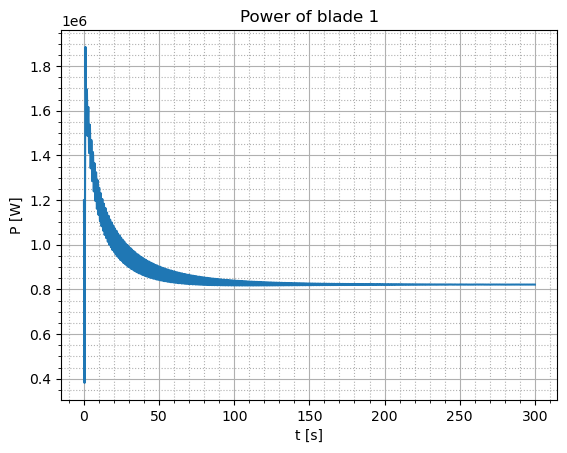

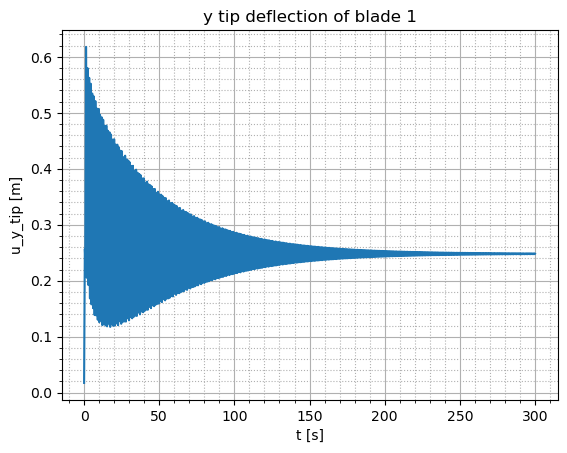

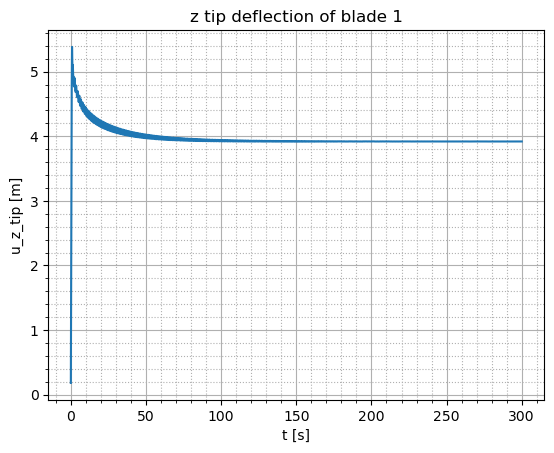

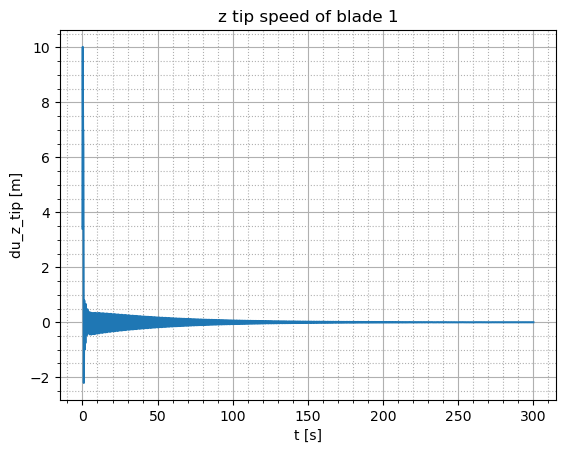

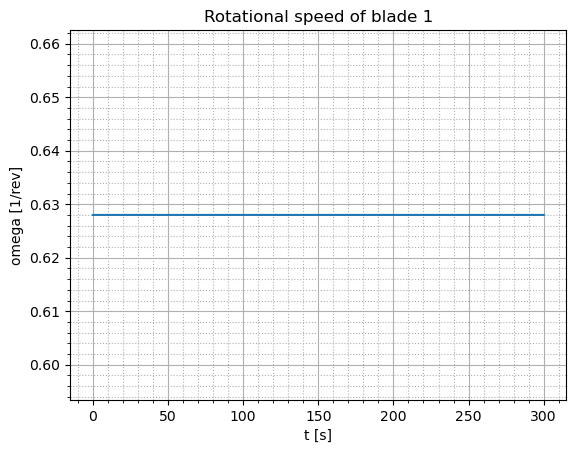

In [22]:
print(solu.keys(), solu['time'].shape, solu['x_array'].shape)
print(solu['x_array'].shape)

fig, ax = plt.subplots()
ax.plot(solu['time'], solu["P"][:,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('P [W]')
ax.set_title('Power of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_P_blade1.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu['time'], solu['u_array'][:,0,-1,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_y_tip [m]')
ax.set_title('y tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uy_blade1.png", dpi=600)

# plt.figure()
# plt.plot(r_array, solu['u_array'][-1,0,:,0])
# plt.xlabel('r [m]')
# plt.ylabel('u_y [m]')
# plt.title('y deflection of blade 1 at last time step')
# plt.show()

fig, ax = plt.subplots()
ax.plot(solu['time'], solu['u_array'][:,0,-1,1])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_z_tip [m]')
ax.set_title('z tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uz_blade1.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu['time'], solu['du_array'][:,0,-1,1])
ax.set_xlabel('t [s]')
ax.set_ylabel('du_z_tip [m]')
ax.set_title('z tip speed of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines

# plt.figure()
# plt.plot(r_array, solu['u_array'][-1,0,:,1])
# plt.xlabel('r [m]')
# plt.ylabel('u_z [m]')
# plt.title('z deflection of blade 1 at last time step')
# plt.show()



fig, ax = plt.subplots()
ax.plot(solu['time'], solu["omega"])
ax.set_xlabel('t [s]')
ax.set_ylabel('omega [1/rev]')
ax.set_title('Rotational speed of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_omega_blade1.png", dpi=600)


# skip = 1
# cut = 10
# speed = 1

# fig, ax = plt.subplots()
# line = ax.plot(r_array, solu['u_array'][0,0,:,0])[0]
# ax.set(xlim=[min(r_array), max(r_array)], ylim=[np.min(solu['u_array'][:,0,:,0]), np.max(solu['u_array'][:,0,:,0])])
# ax.set_xlabel('r [m]')
# ax.set_ylabel('u_y [m]')
# ax.set_title('y deflection of blade 1')

# time_text = ax.text(0.95, 0.95, 'Time: {:.2f} s'.format(solu["time"][0]), transform=ax.transAxes, ha='right', va='top')

# def update(frame):
#     # line.set_xdata(r_array)
#     line.set_ydata(solu['u_array'][frame*skip,0,:,0])

#     time_text.set_text('Time: {:.2f} s'.format(solu["time"][frame*skip]))
#     return line

# ani = animation.FuncAnimation(fig=fig, func=update, frames=m.floor(len(solu['u_array'][:,0,0,0])/skip/cut), interval=solu["dt"]*1000*skip/speed)
# ani.save("A3_Q1_uy_anim.gif")


# fig, ax = plt.subplots()
# line = ax.plot(r_array, solu['u_array'][0,0,:,1])[0]
# ax.set(xlim=[min(r_array), max(r_array)], ylim=[np.min(solu['u_array'][:,0,:,1]), np.max(solu['u_array'][:,0,:,1])])
# ax.set_xlabel('r [m]')
# ax.set_ylabel('u_z [m]')
# ax.set_title('z deflection of blade 1')

# time_text = ax.text(0.95, 0.95, 'Time: {:.2f} s'.format(solu["time"][0]), transform=ax.transAxes, ha='right', va='top')

# def update(frame):
#     # line.set_xdata(r_array)
#     line.set_ydata(solu['u_array'][frame*skip,0,:,1])

#     time_text.set_text('Time: {:.2f} s'.format(solu["time"][frame*skip]))
#     return line

# ani = animation.FuncAnimation(fig=fig, func=update, frames=m.floor(len(solu['u_array'][:,0,0,1])/skip/cut), interval=solu["dt"]*1000*skip/speed)
# ani.save("A3_Q1_uz_anim.gif")

In [24]:
## Q1 TURBULENCE

umean = 7

n1=4096
n2=32
n3=32

Lx=409.5 *umean
Ly=180
Lz=180

deltay=Ly/(n2-1)
deltax=Lx/(n1-1)
deltaz=Lz/(n3-1)
deltat=deltax/umean

print(deltat)

ushp_all = []

for j in range(1,4):
    
    file = os.path.join(os.pardir, "sim_files", "sim"+str(j)+"_"+str(umean)+"_"+str(round(deltat/0.01)*0.01)+".bin")
    # file = "sim"+str(j)+"_"+str(i)+".bin"

    # Load in the files and reshape them into 3D
    u = load(file,  N=(n1, n2, n3))
    ushp = np.reshape(u, (n1, n2, n3))
    ushp_all.append(ushp)

# fluctuations in CS1
fluc_z = ushp_all[0]
fluc_y = - ushp_all[1]
fluc_x = ushp_all[2]

y_sample = ( np.arange(0, Ly+deltay, deltay) - (Ly/2) ) * (-1)
x_sample = np.arange(0, Lz+deltaz, deltaz) - (Lz/2) + H

solu_turb = aeroelasticity(turb=True, t_total=300, dt=deltat, V0=umean, omega=0.628, theta_pitch=0,M_matrix = M3_matrix, C_matrix = C3_matrix, K_matrix = K3_matrix)

0.09999999999999999
-1 [0. 0. 0.]
residual is  [76963.39084715  5142.40549012 13170.4708029 ]
r_max is  76963.39084714938
residual is  [-1.81898940e-12 -8.52651283e-13 -1.36424205e-12]
r_max is  1.8189894035458565e-12
condition reached at 2 steps
0 [2.59780502 0.11550761 0.75716836]
residual is  [-13555.57977559  -4099.65719619 -15988.06948752]
r_max is  15988.069487515912
residual is  [ 3.63797881e-12 -2.27373675e-13  0.00000000e+00]
r_max is  3.637978807091713e-12
condition reached at 2 steps
1 [7.23398836 0.24990751 1.32266052]
residual is  [-40360.70240507  -5148.97473544 -19674.56741603]
r_max is  40360.702405068376
residual is  [7.27595761e-12 9.09494702e-13 0.00000000e+00]
r_max is  7.275957614183426e-12
condition reached at 2 steps
2 [10.06823682  0.18017781 -0.12604171]
residual is  [-34894.25439681  -1626.33025473   8648.18347919]
r_max is  34894.254396805394
residual is  [ 7.27595761e-12 -4.54747351e-13  9.09494702e-13]
r_max is  7.275957614183426e-12
condition reached at 2 

/var/folders/0q/g07hl3q54rq7ll1yvtdj0xd40000gn/T/ipykernel_73736/3574586119.py:208: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f_u = interp2d(y_sample, x_sample, fluc_x[n])
/var/folders/0q/g07hl3q54rq7ll1yvtdj0xd40000gn/T/ipykernel_73736/3574586119.py:209: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2

10 [-1.0183906   1.05401557 -0.39724406]
residual is  [ -427.16026568 -9532.75055889 -4155.47071954]
r_max is  9532.750558894999
residual is  [-1.45519152e-11 -1.81898940e-12 -1.81898940e-12]
r_max is  1.4551915228366852e-11
condition reached at 2 steps
11 [-0.47954168  1.02468515  0.66344312]
residual is  [ -4726.12098494  -8356.66743967 -12830.4560769 ]
r_max is  12830.456076896196
residual is  [ 1.45519152e-11  0.00000000e+00 -3.63797881e-12]
r_max is  1.4551915228366852e-11
condition reached at 2 steps
12 [-0.11407003  0.6019234   0.75698049]
residual is  [-3108.24894267 -2979.02767555 -5132.97328252]
r_max is  5132.973282517165
residual is  [0. 0. 0.]
r_max is  0.0
condition reached at 2 steps
13 [-0.00678209 -0.0680973  -0.15327065]
residual is  [-237.12835756 3439.57091055 7748.82797013]
r_max is  7748.8279701318625
residual is  [-1.45519152e-11  0.00000000e+00 -1.81898940e-12]
r_max is  1.4551915228366852e-11
condition reached at 2 steps
14 [-0.00829895 -0.72514929 -0.9015644 ]

/Users/bogusz/anaconda3/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 1000000 is greater than input length  = 1001, using nperseg = 1001
  warnings.warn('nperseg = {0:d} is greater than input length '


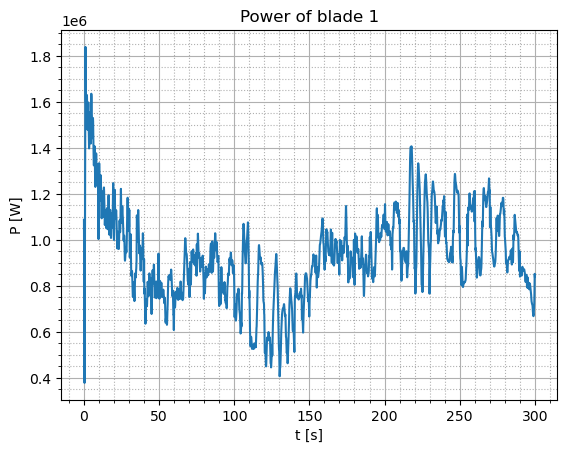

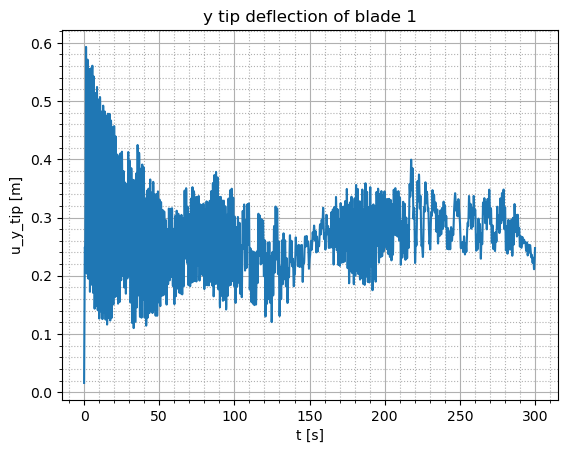

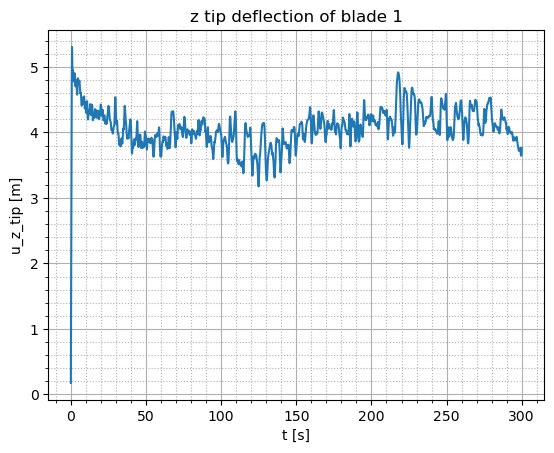

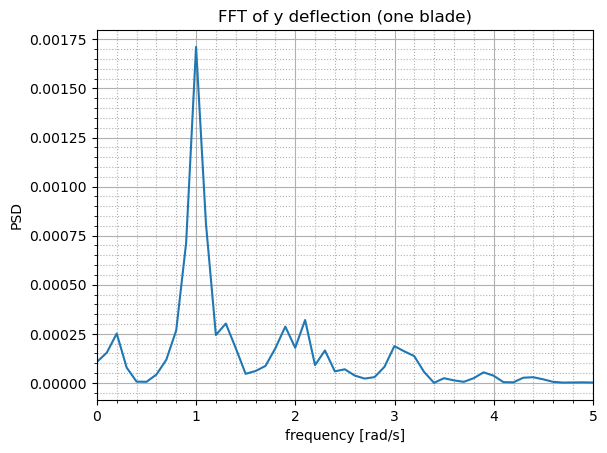

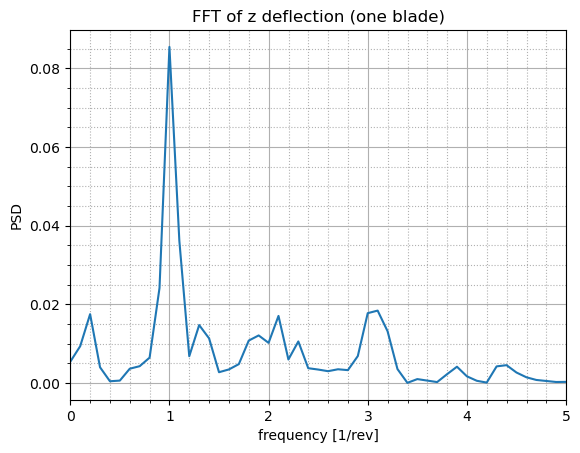

In [25]:
## Q1 TURBULENCE PLOTS

fig, ax = plt.subplots()
ax.plot(solu_turb['time'], solu_turb["P"][:,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('P [W]')
ax.set_title('Power of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_P_blade1_turb.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu_turb['time'], solu_turb['u_array'][:,0,-1,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_y_tip [m]')
ax.set_title('y tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uy_blade1_turb.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu_turb['time'], solu_turb['u_array'][:,0,-1,1])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_z_tip [m]')
ax.set_title('z tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uz_blade1_turb.png", dpi=600)

f, Pxx_den = signal.welch(solu_turb['u_array'][2000:,0,-1,0], fs = 2*np.pi/solu_turb["dt"]/solu_turb["omega"][-1], nperseg=1e6)
fig, ax = plt.subplots(1, 1)
ax.plot(f, Pxx_den, "-")
ax.set_xlabel('frequency [rad/s]')
ax.set_ylabel('PSD')
ax.set_title("FFT of y deflection (one blade)")
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
ax.set_xlim(0, 5)
# ax.set_ylim(0,0.2e6)
fig.savefig("A3_Q1_uy_FFT", dpi=600)

f, Pxx_den = signal.welch(solu_turb['u_array'][2000:,0,-1,1], fs = 2*np.pi/solu_turb["dt"]/solu_turb["omega"][-1], nperseg=1e6)
fig, ax = plt.subplots(1, 1)
ax.plot(f, Pxx_den, "-")
ax.set_xlabel('frequency [1/rev]')
ax.set_ylabel('PSD')
ax.set_title("FFT of z deflection (one blade)")
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
ax.set_xlim(0, 5)
# ax.set_ylim(0,0.2e6)
fig.savefig("A3_Q1_uz_FFT", dpi=600)

In [1]:
## Q2

M5_matrix = np.zeros((5,5))
muz1f = integrate.simpson(y=m_array*u1fz_array , x=r_array)
muz1e = integrate.simpson(y=m_array*u1ez_array , x=r_array)
muz2f = integrate.simpson(y=m_array*u2fz_array , x=r_array)
mxuy1f = integrate.simpson(y=m_array*r_array*u1fy_array , x=r_array)
mxuy1e = integrate.simpson(y=m_array*r_array*u1ey_array , x=r_array)
mxuy2f = integrate.simpson(y=m_array*r_array*u2fy_array , x=r_array)
IM = integrate.simpson(y=m_array*r_array**2 , x=r_array)

M5_matrix[0,0] = mass + 3 * integrate.simpson(y=m_array , x=r_array)
M5_matrix[0,2] = muz1f
M5_matrix[0,3] = muz1e
M5_matrix[0,4] = muz2f 
M5_matrix[1,1] = IM
M5_matrix[1,2] = mxuy1f
M5_matrix[1,3] = mxuy1e
M5_matrix[1,4] = mxuy2f
M5_matrix[2,0] = muz1f
M5_matrix[2,1] = mxuy1f
M5_matrix[2,2] = GM1
M5_matrix[3,0] = muz1e
M5_matrix[3,1] = mxuy1e
M5_matrix[3,3] = GM2
M5_matrix[4,0] = muz2f
M5_matrix[4,1] = mxuy2f
M5_matrix[4,4] = GM3

K5_matrix = np.zeros((5,5))
K5_matrix[0,0] = k_spring
K5_matrix[1,1] = 1e-8
K5_matrix[2,2] = GM1*omega1f**2
K5_matrix[3,3] = GM2*omega1e**2
K5_matrix[4,4] = GM3*omega2f**2

C5_matrix = np.zeros((5,5))

#solu_2 = aeroelasticity(turb=True, t_total=300, dt=deltat, V0=umean, omega=0.628, theta_pitch=0, M_matrix = M5_matrix, C_matrix = C5_matrix, K_matrix = K5_matrix)

NameError: name 'np' is not defined

NameError: name 'solu_2' is not defined

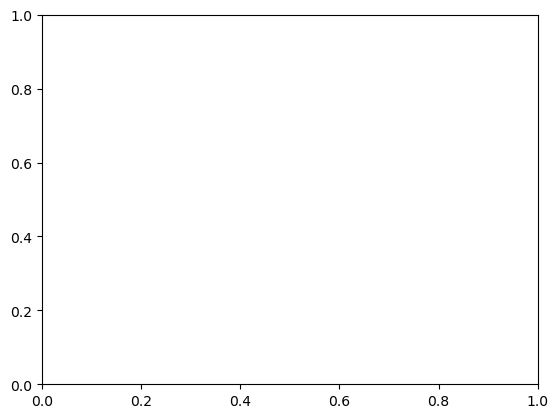

In [30]:
fig, ax = plt.subplots()
ax.plot(solu_2['time'], solu_2['u_array'][:,0,-1,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_y_tip [m]')
ax.set_title('y tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uy_blade1.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu_2['time'], solu_2['u_array'][:,0,-1,1])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_z_tip [m]')
ax.set_title('z tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uz_blade1_turb.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu_2['time'], solu_2['x_array'][:,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_y_tip [m]')
ax.set_title('y tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uy_blade1.png", dpi=600)
